In [1]:
"""
load training data sets and merge them
"""
import pandas as pd
import numpy as np
import os, glob

all_files = glob.glob("training*.csv")
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True)

<BarContainer object of 4607 artists>

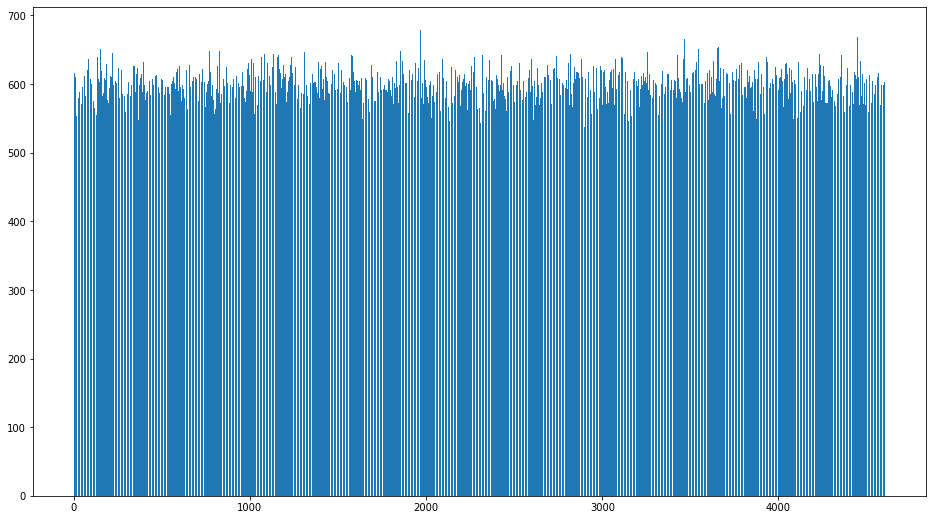

In [2]:
"""
Calculate and plot the missing value numbers of merged training data
"""
import matplotlib.pyplot as plt
null_list=df_merged.isnull().sum()[0:4607].tolist()
plt.figure(figsize=(16,9))
x=range(4607)
plt.bar(x,null_list)

In [3]:
"""
Introduce KNN to complete missing data filling
"""
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(df_merged)
df_imputed5 = pd.DataFrame(imputed, columns=df_merged.columns)

In [4]:
df_imputed5.isnull().sum()

CNNs          0
CNNs.1        0
CNNs.2        0
CNNs.3        0
CNNs.4        0
             ..
GIST.509      0
GIST.510      0
GIST.511      0
label         0
confidence    0
Length: 4610, dtype: int64

In [5]:
"""
Introduce cleanlab to find the error label index
"""
from __future__ import print_function, absolute_import, division, with_statement
import cleanlab
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
# To silence convergence warnings caused by using a weak
# logistic regression classifier on image data
import warnings
warnings.simplefilter("ignore")
np.random.seed(477)

# STEP 0 - Get some real digits data. Add a bunch of label errors. Get probs.
# Get handwritten digits data
X = np.array(df_imputed5.iloc[:,0:4608])
y = df_imputed5.iloc[:,-2]
print('Handwritten digits datasets number of classes:', len(np.unique(y)))
print('Handwritten digits datasets number of examples:', len(y))

s = np.array(df_imputed5.iloc[:,-2].astype(int))

# To keep the tutorial short, we use cleanlab to get the 
# out-of-sample predicted probabilities using cross-validation
# with a very simple, non-optimized logistic regression classifier
psx = cleanlab.latent_estimation.estimate_cv_predicted_probabilities(
    X, s, clf=LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs'))

# Now we have our noisy labels s and predicted probabilities psx.
# That's all we need for confident learning.

#---------------------------------------------

# STEP 1 - Compute confident joint
# Verify inputs
s = np.asarray(s)
psx = np.asarray(psx)

# Find the number of unique classes if K is not given
K = len(np.unique(s))

# Estimate the probability thresholds for confident counting
# You can specify these thresholds yourself if you want
# as you may want to optimize them using a validation set.
# By default (and provably so) they are set to the average class prob.
thresholds = [np.mean(psx[:,k][s == k]) for k in range(K)] # P(s^=k|s=k)
thresholds = np.asarray(thresholds)

# Compute confident joint
confident_joint = np.zeros((K, K), dtype = int)
for i, row in enumerate(psx):
    s_label = s[i]
    # Find out how many classes each example is confidently labeled as
    confident_bins = row >= thresholds - 1e-6
    num_confident_bins = sum(confident_bins)
    # If more than one conf class, inc the count of the max prob class
    if num_confident_bins == 1:
        confident_joint[s_label][np.argmax(confident_bins)] += 1
    elif num_confident_bins > 1:
        confident_joint[s_label][np.argmax(row)] += 1

# Normalize confident joint (use cleanlab, trust me on this)
confident_joint = cleanlab.latent_estimation.calibrate_confident_joint(
    confident_joint, s)

cleanlab.util.print_joint_matrix(confident_joint)
#---------------------------------------------

# STEP 2 - Find label errors

# We arbitrarily choose at least 5 examples left in every class.
# Regardless of whether some of them might be label errors.
MIN_NUM_PER_CLASS = 5
# Leave at least MIN_NUM_PER_CLASS examples per class.
# NOTE prune_count_matrix is transposed (relative to confident_joint)
prune_count_matrix = cleanlab.pruning.keep_at_least_n_per_class(
    prune_count_matrix=confident_joint.T,
    n=MIN_NUM_PER_CLASS,
)

s_counts = np.bincount(s)
noise_masks_per_class = []
# For each row in the transposed confident joint
for k in range(K):
    noise_mask = np.zeros(len(psx), dtype=bool)
    psx_k = psx[:, k]
    if s_counts[k] > MIN_NUM_PER_CLASS:  # Don't prune if not MIN_NUM_PER_CLASS
        for j in range(K):  # noisy label index (k is the true label index)
            if k != j:  # Only prune for noise rates, not diagonal entries
                num2prune = prune_count_matrix[k][j]
                if num2prune > 0:
                    # num2prune'th largest p(classk) - p(class j)
                    # for x with noisy label j
                    margin = psx_k - psx[:, j]
                    s_filter = s == j
                    threshold = -np.partition(
                        -margin[s_filter], num2prune - 1
                    )[num2prune - 1]
                    noise_mask = noise_mask | (s_filter & (margin >= threshold))
        noise_masks_per_class.append(noise_mask)
    else:
        noise_masks_per_class.append(np.zeros(len(s), dtype=bool))

# Boolean label error mask
label_errors_bool = np.stack(noise_masks_per_class).any(axis=0)

 # Remove label errors if given label == model prediction
for i, pred_label in enumerate(psx.argmax(axis=1)):
    # np.all let's this work for multi_label and single label
    if label_errors_bool[i] and np.all(pred_label == s[i]):
        label_errors_bool[i] = False

# Convert boolean mask to an ordered list of indices for label errors
label_errors_idx = np.arange(len(s))[label_errors_bool]
# self confidence is the holdout probability that an example
# belongs to its given class label
self_confidence = np.array(
    [np.mean(psx[i][s[i]]) for i in label_errors_idx]
)
margin = self_confidence - psx[label_errors_bool].max(axis=1)
label_errors_idx = label_errors_idx[np.argsort(margin)]

print('Indices of label errors found by confident learning:')
print('Note label errors are sorted by likelihood of being an error')
print('but here we just sort them by index for comparison with above.')
print(np.array(sorted(label_errors_idx)))

Handwritten digits datasets number of classes: 2
Handwritten digits datasets number of examples: 3615

 Joint Label Noise Distribution Matrix P(s,y) of shape (2, 2)
 p(s,y)	y=0	y=1
	---	---
s=0 |	1350	603
s=1 |	591	1071
	Trace(matrix) = 2421

Indices of label errors found by confident learning:
Note label errors are sorted by likelihood of being an error
but here we just sort them by index for comparison with above.
[   7    8   11 ... 3595 3605 3606]


In [6]:
"""
delete labels with confidence equal to 1.0 in the label_errors_idx
"""
df_tmp=df_imputed5[['label','confidence']]
count=0
del_list=[]
final=np.array(label_errors_idx).tolist()
for x in label_errors_idx:
    if df_tmp.loc[x,'confidence']==1.0:
        final.remove(x)
print(len(final))

918


In [10]:
"""
drop the rows with error labels
"""
new_df_imputed5=df_imputed5.copy()
new_df_imputed5.drop(index = final,inplace = True)   
print(new_df_imputed5.shape)

(2697, 4610)


In [11]:
"""
Augment the training data
"""
double_time_df=pd.concat([new_df_imputed5,new_df_imputed5], ignore_index=True)
print(double_time_df.shape)

(5394, 4610)


In [14]:
"""
Complete the feature selection of training data
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

#df_test=pd.read_csv('test.csv',sep=',')

df=double_time_df
x=df.drop(['label','confidence'], axis=1)
y=df['label']
print(x.shape,y.shape)

# introduce RF to fit x and y
clf = RandomForestClassifier()
clf.fit(x, y)

# sort the features importance
importance = clf.feature_importances_
indices = np.argsort(importance)[::-1]
features = x.columns
features_drop=[]

# choose features whose importance is 0 and drop them in the data
for f in range(x.shape[1]):
    print(("%2d) %-*s %f" % (f + 1, 30, features[indices[f]], importance[indices[f]])))
    if importance[indices[f]]<=0.0001:
        features_drop.append(features[indices[f]])
print(len(features_drop))
print(features_drop)
tmp=df.drop(features_drop,axis=1)

print(tmp.shape)
tmp.to_csv('final_train.csv',index=False)
#tmp_test.to_csv('new_test.csv',index=False)

(5394, 4608) (5394,)
 1) CNNs.3672                      0.011074
 2) CNNs.319                       0.010185
 3) CNNs.2087                      0.009431
 4) CNNs.1253                      0.009247
 5) CNNs.2678                      0.009009
 6) CNNs.1158                      0.008298
 7) CNNs.1687                      0.007959
 8) CNNs.699                       0.007045
 9) CNNs.753                       0.006657
10) CNNs.3924                      0.006414
11) CNNs.2929                      0.005836
12) CNNs.1863                      0.005692
13) CNNs.2298                      0.005611
14) CNNs.501                       0.005492
15) CNNs.703                       0.005160
16) GIST.110                       0.005030
17) CNNs.3015                      0.004911
18) CNNs.1488                      0.004678
19) CNNs.2767                      0.004624
20) CNNs.2448                      0.004587
21) CNNs.1909                      0.004569
22) CNNs.2312                      0.004557
23) CNNs.91

1990) CNNs.713                       0.000120
1991) CNNs.1367                      0.000120
1992) CNNs.1013                      0.000120
1993) CNNs.1096                      0.000120
1994) CNNs.3582                      0.000120
1995) GIST.166                       0.000120
1996) CNNs.638                       0.000120
1997) CNNs.3111                      0.000120
1998) CNNs.3413                      0.000120
1999) CNNs.3752                      0.000120
2000) CNNs.1641                      0.000120
2001) CNNs.2643                      0.000120
2002) CNNs.2764                      0.000120
2003) CNNs.1297                      0.000120
2004) CNNs.1070                      0.000120
2005) CNNs.2742                      0.000120
2006) CNNs.1129                      0.000120
2007) CNNs.2447                      0.000120
2008) CNNs.304                       0.000120
2009) CNNs.3117                      0.000120
2010) CNNs.2315                      0.000120
2011) CNNs.2205                   

3490) CNNs.35                        0.000057
3491) CNNs.930                       0.000057
3492) CNNs.1026                      0.000057
3493) CNNs.3918                      0.000057
3494) CNNs.870                       0.000057
3495) CNNs.1808                      0.000057
3496) CNNs.2399                      0.000057
3497) CNNs.3937                      0.000057
3498) CNNs.389                       0.000057
3499) CNNs.1133                      0.000057
3500) CNNs.1724                      0.000057
3501) CNNs.1125                      0.000057
3502) CNNs.700                       0.000057
3503) CNNs.2077                      0.000057
3504) CNNs.1056                      0.000057
3505) CNNs.2652                      0.000057
3506) CNNs.1429                      0.000057
3507) CNNs.2366                      0.000057
3508) CNNs.2114                      0.000057
3509) CNNs.2663                      0.000057
3510) CNNs.3852                      0.000057
3511) CNNs.2729                   

(5394, 2422)


In [15]:
"""
Finish test data processing
"""
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

#step1 missing data filling
df_test=pd.read_csv('test.csv',sep=',')
imputer_test = KNNImputer(n_neighbors=3)
imputed_test = imputer_test.fit_transform(df_test)
df_imputed5_test = pd.DataFrame(imputed_test, columns=df_test.columns)

# step2 drop irrelevant features
tmp_test=df_imputed5_test.drop(features_drop,axis=1)
print('test data processing done!')

test data processing done!


In [17]:
tmp_test.shape

(2167, 2420)

In [18]:
tmp_test.to_csv('final_test.csv',index=False)
print('done!')

done!
